In [46]:
import cv2

In [47]:
import numpy as np
import time
import matplotlib.pylab as plt

def distance(a, b, A_padding, B, p_size):
    p = p_size // 2
    patch_a = A_padding[a[0]:a[0]+p_size, a[1]:a[1]+p_size, :]
    patch_b = B[b[0]-p:b[0]+p+1, b[1]-p:b[1]+p+1, :]
    temp = patch_b - patch_a
    num = np.sum(1 - np.int32(np.isnan(temp)))
    dist = np.sum(np.square(np.nan_to_num(temp))) / num
    return dist

def reconstruct_image(f, img_A, img_B):
    A_h, A_w, depth = img_A.shape
    temp = np.zeros_like(img_A)
    for i in range(A_h):
        for j in range(A_w):
            temp[i, j, :] = img_B[f[i, j][0], f[i, j][1], :]
    return temp

def init(A, B, p_size):
    A_h, A_w, depth_A = A.shape
    B_h,B_w, depth_B = B.shape
    p = p_size // 2
    random_B_r = np.random.randint(p, B_h-p, [A_h, A_w])
    random_B_c = np.random.randint(p, B_w-p, [A_h, A_w])
    A_padded = np.ones([A_h+p*2, A_w+p*2, 3]) * np.nan # 
    A_padded[p:A_h+p, p:A_w+p, :] = A
    f = np.zeros([A_h, A_w], dtype=object)
    dist = np.zeros([A_h, A_w])
    for i in range(A_h):
        for j in range(A_w):
            a = np.array([i, j])
            b = np.array([random_B_r[i, j], random_B_c[i, j]], dtype=np.int32)
            f[i, j] = b
            dist[i, j] = distance(a, b, A_padded, B, p_size)
    return f, dist, A_padded

def propagate(f, a, dist, A_padding, B, p_size, is_odd):
    A_h = np.size(A_padding, 0) - p_size + 1
    A_w = np.size(A_padding, 1) - p_size + 1
    x = a[0]
    y = a[1]
    if is_odd:
        d_left = dist[max(x-1, 0), y]
        d_up = dist[x, max(y-1, 0)]
        d_current = dist[x, y]
        idx = np.argmin(np.array([d_current, d_left, d_up]))
        if idx == 1:
            f[x, y] = f[max(x - 1, 0), y]
            dist[x, y] = distance(a, f[x, y], A_padding, B, p_size)
        if idx == 2:
            f[x, y] = f[x, max(y - 1, 0)]
            dist[x, y] = distance(a, f[x, y], A_padding, B, p_size)
    else:
        d_right = dist[min(x + 1, A_h-1), y]
        d_down = dist[x, min(y + 1, A_w-1)]
        d_current = dist[x, y]
        idx = np.argmin(np.array([d_current, d_right, d_down]))
        if idx == 1:
            f[x, y] = f[min(x + 1, A_h-1), y]
            dist[x, y] = distance(a, f[x, y], A_padding, B, p_size)
        if idx == 2:
            f[x, y] = f[x, min(y + 1, A_w-1)]
            dist[x, y] = distance(a, f[x, y], A_padding, B, p_size)




In [48]:
def random_search(f, a, dist, A_padded, B, patch_size, alpha):
    x = a[0]
    y = a[1]
    B_h = np.size(B, 0)
    B_w = np.size(B, 1)
    p = patch_size // 2
    i = 4
    search_h = B_h * alpha ** i
    search_w = B_w * alpha ** i
    b_x = f[x, y][0]
    b_y = f[x, y][1]
    while search_h > 1 and search_w > 1:
        search_min_r = max(b_x - search_h, p)
        search_max_r = min(b_x + search_h, B_h-p)
        random_b_x = np.random.randint(search_min_r, search_max_r)
        search_min_c = max(b_y - search_w, p)
        search_max_c = min(b_y + search_w, B_w - p)
        random_b_y = np.random.randint(search_min_c, search_max_c)
        search_h = B_h * alpha ** i
        search_w = B_w * alpha ** i
        b = np.array([random_b_x, random_b_y])
        d = distance(a, b, A_padded, B, patch_size)
        if d < dist[x, y]:
            dist[x, y] = d
            f[x, y] = b
        i += 1

In [49]:
def nearest_neighbor_field(img, ref, p_size, iter_count):
    A_h, A_w, depth = img.shape
    f, dist, img_padding = init(img, ref, p_size)
    for iter_count in range(1, iter_count + 1):
        if iter_count % 2 == 0:
            for i in range(A_h - 1, -1, -1):
                for j in range(A_w - 1, -1, -1):
                    a = np.array([i, j])
                    propagate(f, a, dist, img_padding, ref, p_size, False)
                    random_search(f, a, dist, img_padding, ref, p_size, 0.5)
        else:
            for i in range(A_h):
                for j in range(A_w):
                    a = np.array([i, j])
                    propagate(f, a, dist, img_padding, ref, p_size, True)
                    random_search(f, a, dist, img_padding, ref, p_size, 0.5)
        print("iter %d" % (iter_count))
    return f

In [50]:

img = plt.imread("frames/v001.jpg")
ref = plt.imread("frames/v012.jpg")
p_size = 3
itr = 4
start = time.time()
print("started...")
f = nearest_neighbor_field(img, ref, p_size, itr)
end = time.time()
print("time: ", end - start)
reconstructed = np.zeros(img.shape, dtype=np.float)
reconstructed = reconstruct_image(f, img, ref)

started...
iter 1
iter 2
iter 3
iter 4
time:  112.29800391197205


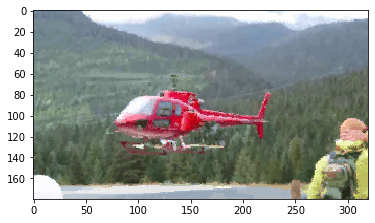

In [51]:
plt.imshow(reconstructed)